<a href="https://colab.research.google.com/github/QingyunSun/Distributional-Robust-Kelly-Gambling/blob/master/DRKP20200610_CVXLayers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install --upgrade cvxpy

get_ipython().run_line_magic('pylab', 'inline')
import numpy as np
import cvxpy as cvx
import itertools
import torch
from tqdm.notebook import tqdm




Requirement already up-to-date: cvxpy in /usr/local/lib/python3.6/dist-packages (1.1.1)
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['seed', 'pi', 'std', 'beta']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [21]:
cvx.__version__

'1.1.1'

In [0]:

n = 20 # number of assets
K = int(n*(n-1)/2)# number of scenarios

# Monte Carlo sample
MC_N_SAMPLES = 100
MC_T = 50

N_TRAJ = 30

M = 1

import cvxpy as cvx
from cvxpylayers.torch import CvxpyLayer
# generate_ball_problem
pi_0 = cvx.Parameter(K, nonneg=True)
# rho_log = cvx.Parameter(K)
# rho = cvx.exp(rho_log)
rho = cvx.Parameter(K, nonneg=True)
R_cvx = cvx.Parameter((n,K), nonneg=True)


b = cvx.Variable(n)
mu = cvx.Variable(K)
log_growth = cvx.log(R_cvx.T@b )
rob_growth_rate = cvx.min(log_growth + mu  )
rob_growth_rate = rob_growth_rate - pi_0.T@mu - rho.T@cvx.abs(mu)
constraints = [cvx.sum(b) == 1, b >= 0] 
DRKP = cvx.Problem(cvx.Maximize(rob_growth_rate), constraints)

problem = DRKP
parameters=[R_cvx, pi_0, rho]

# assert problem.is_dcp()
policy =  CvxpyLayer(problem, parameters, [b])

In [23]:
# # Definitions 
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()
    
std = 0.5
seed = 2018
print('seed', seed)
np.random.seed(seed)
skill = np.random.randn(n)
beta = softmax( std*(skill))


TopTwoList = list(itertools.combinations(range(n),2))

pi = np.ones(K)
r = np.zeros((n,K))

for count in range(len(TopTwoList)):
    vector = np.zeros(n)
    first_place = TopTwoList[count][0]
    second_place = TopTwoList[count][1]
    total = beta[first_place]+beta[second_place]
    vector[first_place] = n*beta[second_place]/total
    vector[second_place] = n*beta[first_place]/total
    r[:,count]=vector

    pi[count] = beta[second_place]*beta[first_place]*(1/(1-beta[first_place])+ 1/(1-beta[second_place]))
    
pi /= sum(pi)
pi_horse = pi.copy()

mc_index = np.random.choice(r.shape[1], size = MC_N_SAMPLES * MC_T, p = pi)
T = MC_N_SAMPLES * MC_T
R = r.copy()

seed 2018


In [26]:
seed = 2020
print('seed', seed)
np.random.seed(seed)
NUM_TEST = 20
pi_test_list = []
for count in range(NUM_TEST):
    skill_test = np.random.randn(n)
    std = 1
    beta = softmax( std*(skill_test))


    TopTwoList = list(itertools.combinations(range(n),2))

    pi = np.ones(K)
    r = np.zeros((n,K))

    for count in range(len(TopTwoList)):
        vector = np.zeros(n)
        first_place = TopTwoList[count][0]
        second_place = TopTwoList[count][1]
        total = beta[first_place]+beta[second_place]
        vector[first_place] = n*beta[second_place]/total
        vector[second_place] = n*beta[first_place]/total
        r[:,count]=vector

        pi[count] = beta[second_place]*beta[first_place]*(1/(1-beta[first_place])+ 1/(1-beta[second_place]))
        
    pi /= sum(pi)
    pi_test_list.append( pi.copy() )

Pi_test = np.stack( pi_test_list ,axis=0)   

seed 2020


In [0]:
# Initialize:
Rho = torch.from_numpy(np.ones(K)*1e-4).requires_grad_(True)
log_Pi_0 = torch.from_numpy(np.zeros(K)).requires_grad_(True)
torch_variables = [log_Pi_0, Rho]
R_torch = torch.from_numpy(R)
Pi_test_torch = torch.from_numpy(Pi_test)
# Loss: 
def evaluate( R_torch, log_Pi_0, Rho, Pi_test_torch):
    Pi_0 = torch.nn.functional.softmax(log_Pi_0)
    b, = policy(R_torch, Pi_0, Rho)
    logs = torch.log(R_torch.T @ b)
    cost = torch.sum(Pi_test_torch*logs[None,:])
    return   cost

# Training:
iters = 50
results = []
optimizer = torch.optim.Adam(torch_variables, lr=1e-4)
for i in range(iters):
    optimizer.zero_grad()
    loss = evaluate(R_torch, log_Pi_0, Rho, Pi_test_torch)
    loss.backward()
    optimizer.step()
    # Project so that Rho is non-negative 
    Rho.data = torch.max(Rho.data,torch.zeros_like(Rho.data))
    results.append(loss.item())
    # print("(iter %d) loss: %g " % (i, results[-1]))
 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


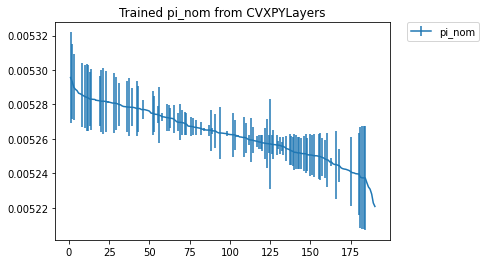

In [38]:
# order = np.argsort(pi_horse)[::-1]
Pi_0 = torch.nn.functional.softmax(log_Pi_0)
pi_0_trained = Pi_0.detach().numpy()

order_trained = np.argsort(pi_0_trained)[::-1]

rho_trained = Rho.detach().numpy()

pi_0_trained_upper = pi_0_trained+rho_trained
pi_0_trained_lower = pi_0_trained-rho_trained

plt.subplot()
width = 2
barWidth = 5

order = np.argsort(pi)[::-1]
plt.errorbar( np.arange(1, K+1 ) , pi_0_trained[order_trained], yerr= pi_0_trained[order_trained]*rho_trained[order_trained], label = 'pi_nom' )

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Trained pi_nom from CVXPYLayers')
plt.show()


In [0]:

# Initialize:
Rho = torch.from_numpy(np.ones(K)*1e-1)
log_Pi_0 = torch.from_numpy( np.log(np.mean(Pi_test, axis=0)) ).requires_grad_(True)
torch_variables = [log_Pi_0, Rho]
R_torch = torch.from_numpy(R)
Pi_test_torch = torch.from_numpy(Pi_test)
# Loss: 
def evaluate( R_torch, log_Pi_0, Rho, Pi_test_torch):
    Pi_0 = torch.nn.functional.softmax(log_Pi_0)
    b, = policy(R_torch, Pi_0, Rho)
    logs = torch.log(R_torch.T @ b)
    cost = - torch.sum(Pi_test_torch*logs[None,:])
    return   cost

# Training:
iters = 160
results = []
optimizer = torch.optim.Adam(torch_variables, lr=1e-6)
for i in range(iters):
    optimizer.zero_grad()
    loss = evaluate(R_torch, log_Pi_0, Rho, Pi_test_torch)
    loss.backward()
    optimizer.step()
    # Project so that Rho is non-negative 
    Rho.data = torch.max(Rho.data,torch.zeros_like(Rho.data))
    results.append(loss.item())
     
 

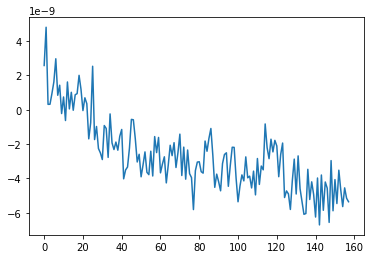

In [92]:
plt.plot(results)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


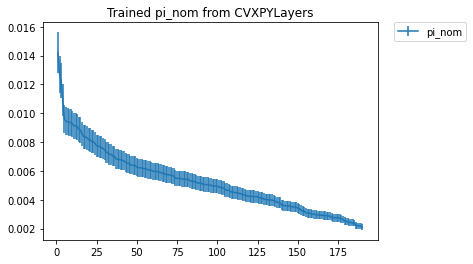

In [93]:
 
Pi_0 = torch.nn.functional.softmax(log_Pi_0)
pi_0_trained = Pi_0.detach().numpy()

order_trained = np.argsort(pi_0_trained)[::-1]

rho_trained = Rho.detach().numpy()

pi_0_trained_upper = pi_0_trained+rho_trained
pi_0_trained_lower = pi_0_trained-rho_trained

plt.subplot()
width = 2
barWidth = 5

order = np.argsort(pi)[::-1]
plt.errorbar( np.arange(1, K+1 ) , pi_0_trained[order_trained], yerr= pi_0_trained[order_trained]*rho_trained[order_trained], label = 'pi_nom' )

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Trained pi_nom from CVXPYLayers')
plt.show()


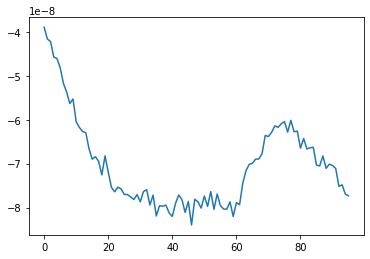

In [89]:
plt.plot(results)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


(iter 0) loss: 1.46575e-11 
(iter 1) loss: 4.05989e-09 
(iter 2) loss: -3.92501e-09 
(iter 3) loss: 2.9974e-10 
(iter 4) loss: -2.99795e-09 
(iter 5) loss: -1.286e-09 
(iter 6) loss: -3.555e-09 
(iter 7) loss: -6.00079e-09 
(iter 8) loss: -7.28218e-09 
(iter 9) loss: -6.026e-09 
(iter 10) loss: -9.25404e-09 
(iter 11) loss: -1.257e-08 
(iter 12) loss: -1.30484e-08 
(iter 13) loss: -1.36508e-08 
(iter 14) loss: -1.45596e-08 
(iter 15) loss: -1.49152e-08 
(iter 16) loss: -1.65922e-08 
(iter 17) loss: -1.75623e-08 
(iter 18) loss: -1.8555e-08 
(iter 19) loss: -1.80029e-08 
(iter 20) loss: -1.91127e-08 
(iter 21) loss: -1.979e-08 
(iter 22) loss: -2.14284e-08 
(iter 23) loss: -2.33379e-08 
(iter 24) loss: -2.40969e-08 
(iter 25) loss: -2.72987e-08 
(iter 26) loss: -2.80728e-08 
(iter 27) loss: -2.87882e-08 
(iter 28) loss: -3.21956e-08 
(iter 29) loss: -3.30433e-08 
(iter 30) loss: -3.13633e-08 
(iter 31) loss: -3.70404e-08 
(iter 32) loss: -3.71752e-08 
(iter 33) loss: -3.97306e-08 
(iter

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


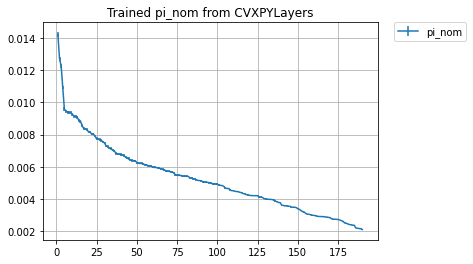

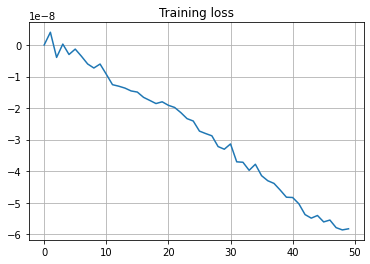

In [135]:

# Initialize:
Rho = torch.from_numpy(np.ones(K)*1e-2).requires_grad_(True)
log_Pi_0 = torch.from_numpy( np.log(np.mean(Pi_test, axis=0)) )
torch_variables = [log_Pi_0, Rho]
R_torch = torch.from_numpy(R)
Pi_test_torch = torch.from_numpy(Pi_test)
# Loss: 
def evaluate( R_torch, log_Pi_0, Rho, Pi_test_torch):
    Pi_0 = torch.nn.functional.softmax(log_Pi_0)
    b, = policy(R_torch, Pi_0, Rho)
    logs = torch.log(R_torch.T @ b)
    cost = - torch.sum(Pi_test_torch*logs[None,:])
    return   cost

# Training:
iters = 50
results = []
optimizer = torch.optim.Adam(torch_variables, lr=1e-6)
for i in range(iters):
    optimizer.zero_grad()
    loss = evaluate(R_torch, log_Pi_0, Rho, Pi_test_torch)
    loss.backward()
    optimizer.step()
    # Project so that Rho is non-negative 
    Rho.data = torch.max(Rho.data,torch.zeros_like(Rho.data))
    results.append(loss.item())
    print("(iter %d) loss: %g " % (i, results[-1]))
 





# order = np.argsort(pi_horse)[::-1]
Pi_0 = torch.nn.functional.softmax(log_Pi_0)
pi_0_trained = Pi_0.detach().numpy()

order_trained = np.argsort(pi_0_trained)[::-1]

rho_trained = Rho.detach().numpy()

pi_0_trained_upper = pi_0_trained+rho_trained
pi_0_trained_lower = pi_0_trained-rho_trained

plt.subplot()
width = 2
barWidth = 5

order = np.argsort(pi)[::-1]
plt.errorbar( np.arange(1, K+1 ) , pi_0_trained[order_trained], yerr= pi_0_trained[order_trained]*rho_trained[order_trained], label = 'pi_nom' )

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Trained pi_nom from CVXPYLayers')
plt.grid()
plt.show()

plt.plot(results )
plt.title('Training loss')
plt.grid()
plt.show()
